In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from pytorch_lightning import Trainer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from pytorch_lightning import Trainer
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from torch.utils.tensorboard import SummaryWriter


/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1> Load data and retrieve catergorical and numerical columns

In [2]:
# Load the dataset
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [3]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [4]:
# Split the dataset into features and target
X = df.drop('y', axis=1)
y = df['y']
trainDf = X
# Select numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
# Standardize the numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
print('X shape: ', X.shape)
# Select categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

X shape:  (41188, 20)


In [5]:
# Encode the target variable
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 0, 0, ..., 0, 1, 0])

In [6]:
print('# numerical cols', len(numerical_cols))
numerical_cols

# numerical cols 10


Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [7]:
print('# categorical cols',len(categorical_cols))
categorical_cols

# categorical cols 10


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

<h4> Encode and map categorical based on int values

In [8]:
# Category Mapping
cat_dict = {}
for col in categorical_cols:
    # create a category column from the original column
    category_col = trainDf[col].astype('category')
    # create a dictionary for the column to store category to code mapping
    cat_dict[col] = {value: idx for idx, value in enumerate(category_col.cat.categories)} 
# check the category to code mapping for the education column
cat_dict['education']


{'basic.4y': 0,
 'basic.6y': 1,
 'basic.9y': 2,
 'high.school': 3,
 'illiterate': 4,
 'professional.course': 5,
 'university.degree': 6,
 'unknown': 7}

In [9]:
def encode_dataframe(cat_dict, df):
    # Create a new DataFrame with a subset of columns
    tempDf = df[list(cat_dict.keys())]
    # Iterate over the columns in the new DataFrame
    for column in tempDf.columns:
        if column in cat_dict:
            # Replace the values in the column with the encoded values
            tempDf[column] = tempDf[column].replace(cat_dict[column])
    return tempDf

categoricalCols = encode_dataframe(cat_dict, X)

In [10]:
categoricalCols.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [11]:
numericalCols = X[numerical_cols] # Getting all the numerical columns

In [12]:
numericalCols.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533034,0.010471,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
1,1.628993,-0.421501,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
2,-0.290186,-0.124520,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
3,-0.002309,-0.413787,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168
4,1.533034,0.187888,-0.565922,0.195414,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168


In [13]:
# Compute sizeDict containing the #unique values in each catergorical columns
sizeDict = []
for k in cat_dict:
    sizeDict.append(len(cat_dict[k]))
sizeDict

[12, 4, 8, 3, 3, 3, 2, 10, 5, 3]

In [14]:
# Convert dataframe to tensors
numerical_data = torch.tensor(numericalCols.values, dtype=torch.float32)
categorical_data = torch.tensor(categoricalCols.values, dtype=torch.int64)

In [15]:
# Check shapes
categorical_data.shape, numerical_data.shape

(torch.Size([41188, 10]), torch.Size([41188, 10]))

In [16]:
# Define a PyTorch neural network class called "BankMarketingModel" which inherits from the PyTorch "nn.Module" class
class BankMarketingModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, embedding_dim, num_layers):
        super(BankMarketingModel, self).__init__()
        # self.embedding" is a list of PyTorch "nn.Embedding" layers, created using a list comprehension with 
        # the "in_dim" and "emb_dim" values coming from the "input_dim" and "embedding_dim" lists passed as arguments
        self.embedding = nn.ModuleList([nn.Embedding(in_dim, emb_dim) for in_dim, emb_dim in zip(input_dim, embedding_dim)])
        # self.linear1" is a PyTorch "nn.Linear" layer with input size being the sum of the values 
        # in "embedding_dim" list and the number of numerical columns and output size of "hidden_dim" passed as an argument.
        self.linear1 = nn.Linear(sum(embedding_dim) + len(numerical_cols), hidden_dim)
        # Similarily for linear layer 2, appropriate dimensions
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.num_layers = num_layers

    def forward(self, x_cat, x_num):
        # Pass the categorical data through the embedding layers
        # Feed categorical features to the embedding layer
        x_cat = [emb(x_cat[:, i]) for i, emb in enumerate(self.embedding)] 
        x_cat = torch.cat(x_cat, 1)
        # Combine embedded and numerical features
        x = torch.cat([x_cat, x_num], 1)
        # Feed to the linear layer(s)
        x = F.relu(self.linear1(x))
        for _ in range(self.num_layers - 1):
            x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return torch.sigmoid(x)


In [17]:
# Define required params
input_dim = sizeDict
output_dim = 1
hidden_dim = 110
embedding_dim = [10 for _ in range(10)]
num_layers = 5
# Define the number of folds
n_folds = 3
max_epochs = 100 #Maximum Epochs

# Instantiate the model
model = BankMarketingModel(input_dim, output_dim, hidden_dim, embedding_dim, num_layers)
# Pass the data through the model
output = model(categorical_data, numerical_data)

# Define the loss function
loss_fn = nn.BCELoss()
labels = torch.tensor(y)
labels = torch.reshape(labels, (labels.shape[0], 1))
labels = labels.to(torch.float)
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())
# Define the threshold for converting probabilities to binary values
threshold = 0.5
# Create a DataLoader from the TensorDataset
batch_size = 4000

In [18]:
class BankMarketingModule(LightningModule):
    def __init__(self, input_dim, output_dim, hidden_dim, embedding_dim, num_layers):
        super().__init__()
        # Instantiate the model
        self.model = BankMarketingModel(input_dim, output_dim, hidden_dim, embedding_dim, num_layers)
        # Define and initiate params
        self.val_losses = []
        self.train_losses = []
        self.train_accs = []
        self.val_accs = []
        self.current_train_loss = 0
        self.current_train_acc = 0
        self.current_fold = 0
        self.n_folds = 3

    def forward(self, x_cat, x_num):
        # forward pass
        return self.model(x_cat, x_num)

    def training_step(self, batch, batch_idx):
        x_cat, x_num, y = batch
        # print('Sizes: x_cat: {}, x_num: {}, y: {}'.format(x_cat.shape, x_num.shape, y.shape))
        y_hat = self.forward(x_cat, x_num) # forward pass
        loss = F.binary_cross_entropy(y_hat, y) #computing loss
        acc = (y_hat.round() == y).sum().item() / len(y) # accuracy
        # Store accuracy and loss for plotting later on
        self.train_losses.append((loss, batch_idx))
        self.train_accs.append((acc, batch_idx))
        return {'accuracy': acc, 'loss': loss}

    def validation_step(self, batch, batch_idx):
        x_cat, x_num, y = batch # get data and labels
        y_hat = self.forward(x_cat, x_num) # forward pass
        loss = F.binary_cross_entropy(y_hat, y) #computing loss
        acc = (y_hat.round() == y).sum().item() / len(y) # accuracy
        # Store accuracy and loss for plotting later on
        self.val_losses.append((loss, batch_idx))
        self.val_accs.append((acc, batch_idx))
        return {'val_loss': loss, 'val_acc': torch.tensor(acc)}

    def configure_optimizers(self):
        # Optimizer setup, to be used when model is trained
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        # Creating data loader to allow for Trainer to train this using this loader
        train_data = TensorDataset(categorical_data, numerical_data, labels)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        return train_loader




In [19]:
# Function to handle tensors returned for training and validation
# loss and accuracies, utlized to convert them into a list and then plotted later
def getVals(lst, epochs):
    pat = int(len(lst)/max_epochs)
    try:
        lstt = [(float(x[0].detach().numpy()), x[1]) for x in lst]
    except:
        lstt = lst
    lst = [x[0] for x in lstt]
    out = []
    for i in range(epochs):
        c = lst[i:i+pat]
        out.append(np.mean(c))
    return out

<h1> I have plotted graphs below and using tensorboard as well, however it is suggested to refer to these graphs first.

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/farjad.ahmed/Documents/Studies/ML Lab/Exercise_08/lightning_logs

  | Name  | Type               | Params
---------------------------------------------
0 | model | BankMarketingModel | 12.9 K
---------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 27.10it/s, loss=0.113, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 26.89it/s, loss=0.113, v_num=0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | BankMarketingModel | 12.9 K
---------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 27.16it/s, loss=0.139, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 26.97it/s, loss=0.139, v_num=1]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type               | Params
---------------------------------------------
0 | model | BankMarketingModel | 12.9 K
---------------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 26.62it/s, loss=0.149, v_num=2]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 11/11 [00:00<00:00, 26.29it/s, loss=0.149, v_num=2]



				********************Results********************


Train_Accuracy 1.0
Train_Loss 0.0
Validation_Accuracy 1.0
Validation_Loss 0.0


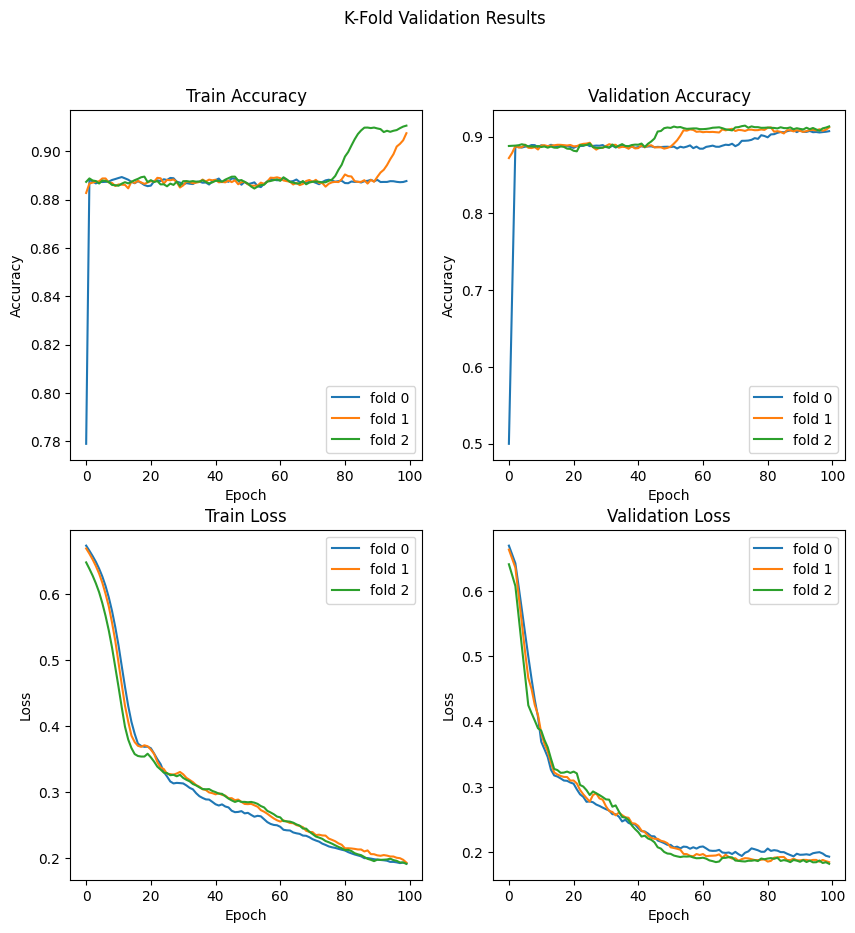

In [20]:
# Lists to store the metrics, result dict to cumulate the results for kfolds
avgTrainLoss = []
avgValLoss = []
avgTrainAcc = []
avgValAcc = []
resultDict = {'Train_Accuracy':0, 'Train_Loss':0, 'Validation_Accuracy':0, 'Validation_Loss':0}
# Tensor Board
writer = SummaryWriter()
# Convert data to tensors
labels = torch.tensor(y)
labels = torch.reshape(labels, (labels.shape[0], 1))
labels = labels.to(torch.float)
# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# Create a TensorDataset
train_data = TensorDataset(categorical_data, numerical_data, labels)
lines = [[] for _ in range(4)] 
# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Iterate over the folds
for i, (train_index, val_index) in enumerate(skf.split(categorical_data, labels)):
    # Create train and validation data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(train_index))
    val_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(val_index))

    # Create a new instance of the model for each fold
    model = BankMarketingModule(input_dim, output_dim, hidden_dim, embedding_dim, num_layers)
    # trainer = Trainer(max_epochs=100)
    trainer = Trainer(max_epochs=max_epochs)
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    # Retrieve the following values and store them for each batch
    trainAccs = getVals(model.train_accs, max_epochs)
    valAccs = getVals(model.val_accs, max_epochs)
    trainLoss = getVals(model.train_losses, max_epochs)
    valLoss = getVals(model.val_losses, max_epochs)
    # Store them in the lists
    avgTrainLoss.append(trainLoss)
    avgValLoss.append(valLoss)
    avgTrainAcc.append(trainAccs)
    avgValAcc.append(valAccs)
    # Log the training and validation loss and accuracy to TensorBoard
    for epoch, (train_loss, train_acc, val_loss, val_acc) in enumerate(zip(trainLoss, trainAccs, valLoss, valAccs)):
        writer.add_scalar('fold_{}/train_loss'.format(i), train_loss, epoch)
        writer.add_scalar('fold_{}/train_acc'.format(i), train_acc, epoch)
        writer.add_scalar('fold_{}/val_loss'.format(i), val_loss, epoch)
        writer.add_scalar('fold_{}/val_acc'.format(i), val_acc, epoch)
    # Plot the data
    lines[0].append(axs[0, 0].plot(trainAccs)[0])
    lines[1].append(axs[0, 1].plot(valAccs)[0])
    lines[2].append(axs[1, 0].plot(trainLoss)[0])
    lines[3].append(axs[1, 1].plot(valLoss)[0])
    
    resultDict['Train_Accuracy'] += np.mean(trainAccs)
    resultDict['Train_Loss'] += np.mean(trainLoss)
    resultDict['Validation_Accuracy'] += np.mean(valAccs)
    resultDict['Validation_Loss'] += np.mean(valLoss)
# To compute and print the avg performance results for KFOLDS
print("\n\n\n\t\t\t\t********************Results********************\n\n")
for keys in resultDict:
    print(keys, np.round(resultDict[keys]/n_folds))
# Generating graphs
for i, ax in enumerate(axs.flatten()):
    ax.legend(handles=lines[i], labels=['fold {}'.format(i) for i in range(n_folds)])
# Add labels to the plots
axs[0, 0].set_title("Train Accuracy")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Accuracy")

axs[0, 1].set_title("Validation Accuracy")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Accuracy")

axs[1, 0].set_title("Train Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")

axs[1, 1].set_title("Validation Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Loss")

fig.suptitle("K-Fold Validation Results")
plt.show()
writer.close()

In [21]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.
